In [63]:
# import nltk
# nltk.download('all')

In [64]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn import metrics
import matplotlib.pyplot as plt
import string, re, emoji

# Limpieza de textos
from pattern.text.en import singularize, lemma
from nltk.corpus import stopwords
from wordcloud import WordCloud

from transformers import AutoTokenizer,TFBertModel
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy,BinaryCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy,BinaryAccuracy
from tensorflow.keras.utils import plot_model
import tensorflow
from sklearn.metrics import accuracy_score

pd.options.display.max_rows = None

# Carga de datos

In [65]:
'''
  id - a unique identifier for each tweet
  text - the text of the tweet
  location - the location the tweet was sent from (may be blank)
  keyword - a particular keyword from the tweet (may be blank)
  target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)
'''
train = pd.read_csv('./train.csv', encoding='utf8')
test = pd.read_csv('./test.csv', encoding='utf8')

cachedStopWords = stopwords.words('english')

# Analisis Exploratorio I

<AxesSubplot:>

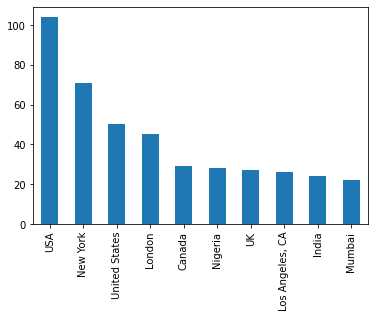

In [66]:
train['location'].value_counts().head(10).plot.bar()

<AxesSubplot:>

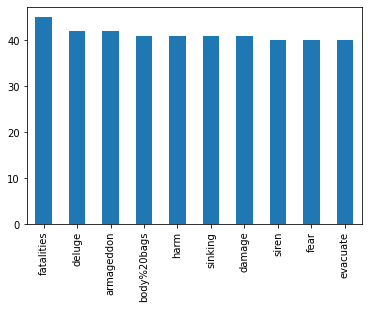

In [67]:
train['keyword'].value_counts().head(10).plot.bar()

<AxesSubplot:>

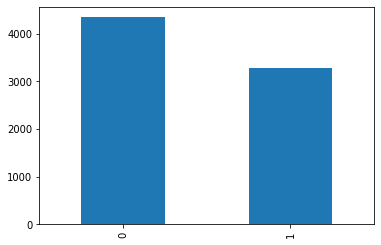

In [68]:
train['target'].value_counts().plot.bar()

In [69]:
train['text']

0       Our Deeds are the Reason of this #earthquake M...
1                  Forest fire near La Ronge Sask. Canada
2       All residents asked to 'shelter in place' are ...
3       13,000 people receive #wildfires evacuation or...
4       Just got sent this photo from Ruby #Alaska as ...
5       #RockyFire Update => California Hwy. 20 closed...
6       #flood #disaster Heavy rain causes flash flood...
7       I'm on top of the hill and I can see a fire in...
8       There's an emergency evacuation happening now ...
9       I'm afraid that the tornado is coming to our a...
10            Three people died from the heat wave so far
11      Haha South Tampa is getting flooded hah- WAIT ...
12      #raining #flooding #Florida #TampaBay #Tampa 1...
13                #Flood in Bago Myanmar #We arrived Bago
14      Damage to school bus on 80 in multi car crash ...
15                                         What's up man?
16                                          I love fruits
17            

# Limpieza de datos

In [70]:
train.columns

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')

## Location

In [71]:
def cleanCountry(value):
  try:

    if (
      'nan' in value or
      'world' in value or
      'global' in value or
      'everywhere' in value or
      'earth' in value or
      'ss' in value or
      '?' in value or
      re.search(r"[0-9]+", value, re.I)
    ):
      return 'unknow'

    if (
      'italy' in value
    ):
      return 'italy'

    if (
      'india' in value or
      'mumbai' in value
    ):
      return 'india'
    
    if (
      'switzerland' in value or
      'geneva' in value
    ):
      return 'switzerland'
    
    if (
      'china' in value or
      'hong kong' in value
    ):
      return 'china'

    if (
      'nigeria' in value or
      'lagos' in value
    ):
      return 'nigeria'

    if (
      'japan' in value or
      'tokyo' in value
    ):
      return 'japan'

    if (
      'ontario' in value or
      'canada' in value or
      'toronto' in value or
      'calgary' in value or
      'alberta' in value or
      re.search(r"ab$", value, re.I) or
      re.search(r"bc$", value, re.I)
    ):
      return 'canada'

    if (
      'uk' == value or
      'united kingdom' in value or
      'kingdom' in value or
      'british' in value or
      'scotland' in value or
      'newcastle' in value or
      'england' in value or
      'london' in value or
      re.search(r"uk$", value, re.I)
    ):
      return 'uk'

    if (
      'nyc' == value or
      'nj' == value or
      'united states' in value or
      'new york' in value or
      'san francisco' in value or
      'los angeles' in value or
      'new jersey' in value or
      'north carolina' in value or
      'st. louis' in value or
      'kansas city' in value or
      'san diego' in value or
      'las vegas' in value or
      'sacramento' in value or
      'oregon' in value or
      'michigan' in value or
      'manchester' in value or
      'portland' in value or
      'texas' in value or
      'u.s.' in value or
      'philippines' in value or
      'nevada' in value or
      'us' in value or
      'arizona' in value or
      'lincoln' in value or
      'wisconsin' in value or
      'pennsylvania' in value or
      'seattle' in value or
      'usa' in value or
      'washington' in value or
      'florida' in value or
      'chicago' in value or
      'california' in value or
      'nashville' in value or
      'colorado' in value or
      'denver' in value or
      'cleveland' in value or
      'atlanta' in value or
      'massachusetts' in value or
      'boston' in value or
      'oklahoma' in value or
      'tennessee' in value or
      'liverpool' in value or
      'phoenix' in value or
      'baltimore' in value or
      re.search(r"nyc$", value, re.I) or
      re.search(r"hi$", value, re.I) or
      re.search(r"va$", value, re.I) or
      re.search(r"ks$", value, re.I) or
      re.search(r"la$", value, re.I) or
      re.search(r"ak$", value, re.I) or
      re.search(r"md$", value, re.I) or
      re.search(r"mo$", value, re.I) or
      re.search(r"wi$", value, re.I) or
      re.search(r"az$", value, re.I) or
      re.search(r"ga$", value, re.I) or
      re.search(r"ok$", value, re.I) or
      re.search(r"nj$", value, re.I) or
      re.search(r"wa$", value, re.I) or
      re.search(r"pa$", value, re.I) or
      re.search(r"ma$", value, re.I) or
      re.search(r"co$", value, re.I) or
      re.search(r"oh$", value, re.I) or
      re.search(r"il$", value, re.I) or
      re.search(r"tn$", value, re.I) or
      re.search(r"dc$", value, re.I) or
      re.search(r"ca$", value, re.I) or
      re.search(r"tx$", value, re.I) or
      re.search(r"nc$", value, re.I) or
      re.search(r"fl$", value, re.I) or
      re.search(r"ny$", value, re.I)
    ):
      return 'usa'

    return value
  except:
    return 'unknow'

train['location'] = train['location'].apply(lambda row: str(row).lower())
train['location'] = train['location'].apply(lambda row: cleanCountry(row))

## Keyword

In [72]:
def toSingular(value):
  try:
    return singularize(value)
  except:
    return value

def parseLemma(value):
  try:
    return lemma(value)
  except:
    return value

def replaceSpace(value):
  return str(value).replace('%20', ' ')

train['keyword'] = train['keyword'].apply(lambda row: toSingular(row))
train['keyword'] = train['keyword'].apply(lambda row: parseLemma(row))
train['keyword'] = train['keyword'].apply(lambda row: replaceSpace(row))
train['keyword'].value_counts()

flood                  109
body bag               107
scream                 105
drown                  104
bomb                   101
fatality                82
sink                    80
weapon                  78
wreck                   76
evacuate                76
death                   74
collide                 74
derail                  73
blaze                   72
quarantine              71
explode                 71
attack                  71
injury                  71
panic                   70
riot                    69
siren                   69
casualty                69
destroy                 69
collapse                69
deluge                  69
hostage                 68
suicide bomb            68
crush                   68
crash                   67
burn                    67
electrocute             66
hijack                  65
survive                 65
demolish                62
obliterate              62
nan                     61
rescue                  57
f

## Text

In [73]:
def removeHastags(value):
  if ('#' not in value): return value
  hashtags = re.findall(r"#[^\s]*", value, re.I)
  for hashtag in hashtags:
    value = value.replace(hashtag, '')
  return value

def removeLinks(value):
  if ('http' not in value): return value
  links = re.findall(r"http[^\s]*", value, re.I)
  for link in links:
    value = value.replace(link, '')
  return value

def removeStepWords(value):
  return ' '.join([word for word in value.split() if word not in cachedStopWords])

def extractEmojis(value):
  items = value.split(' ')
  emojis = ''.join(item for item in items if item in emoji.EMOJI_DATA)

  if (len(emojis) > 0): print(value)

  return value

def sentenceToSingular(value):
  items = value.split(' ')
  for item in items:
    singular = toSingular(item)
    value = value.replace(item, singular)
  return value

def sentenceToPresent(value):
  items = value.split(' ')
  for item in items:
    present = parseLemma(item)
    value = value.replace(item, present)
  return value

translator = str.maketrans(string.punctuation, ' ' * len(string.punctuation))

cleanText = []
for index, row in train.iterrows():
  text = row['text'][:]

  # Limpiando el texto
  text = text.lower()                         # Convierte todo a minusculas
  text = text.replace('utc', '')              # Quita utc
  text = text.replace('#', '')                # Quita #
  text = text.replace('@', '')                # Quita @
  text = removeLinks(text)                    # Quita links
  text = extractEmojis(text)                  # Quita todos los emojis
  text = text.translate(translator)           # Quita todos los signos de puntuacion
  text = removeStepWords(text)                # Quita todas las step words
  text = re.sub('  +', ' ', text)             # Quita todos los espacios de mas
  text = sentenceToSingular(text)             # Pasa las palabras a singular
  text = sentenceToPresent(text)              # Pasa las palabras a presente
  
  numbers = re.findall(r"[0-9]", text, re.I)
  if (len(numbers) > 0):
    for number in numbers:
      if (number == '911'): continue

      # Quitando numeros
      text = text.replace(number, '')

  text = removeStepWords(text)                # Quita todas las step words
  text = re.sub('  +', ' ', text)             # Quita todos los espacios de mas

  cleanText.append(text)

train['text'] = cleanText[:]

In [74]:
for index, row in train.iterrows():
  print(row['text'])

deed reason earthquake may allah forgive u
forest fire near la ronge sask canada
resident ask shelter place notify officer evacuation shelter place order expect
person receive wildfire evacuation order californium
get send photo ruby alaska smoke wildfire pour school
rockyfire update californium hwy close direction due lake county fire cafire wildfire
flood disaster heavy rain cause flash flood street manitou colorado spring area
top hill see fire wood
emergency evacuation happen build acro street
afraid tornado come area
three person die heat wave far
haha south tampa get flood hah wait second live south tampa gonna gonna fvck flood
rain flood florida tampabay tampa day lose count
flood bago myanmar arrive bago
damage school bu multu car crash break
man
love fruit
summer lovely
car fast
goooooooaaaaaal
ridiculou
london cool
love ski
wonderful day
looooool
way eat shit
nyc last week
love girlfriend
cooool
like pastum
end
bbcmtd wholesale market ablaze
alway try bring heavy metal rt
afr

# Analisis Exploratorio II

<AxesSubplot:>

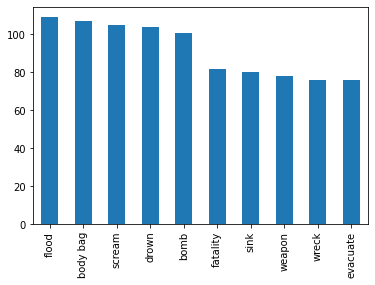

In [75]:
train['keyword'].value_counts().head(10).plot.bar()

<AxesSubplot:>

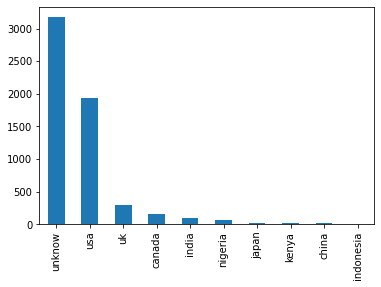

In [76]:
train['location'].value_counts().head(10).plot.bar()

<AxesSubplot:>

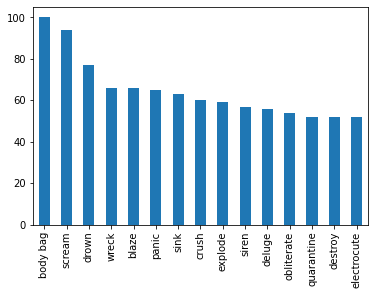

In [77]:
train.loc[train['target'] == 0]['keyword'].value_counts().head(15).plot.bar()

<AxesSubplot:>

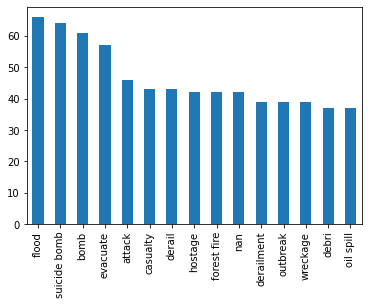

In [78]:
train.loc[train['target'] == 1]['keyword'].value_counts().head(15).plot.bar()

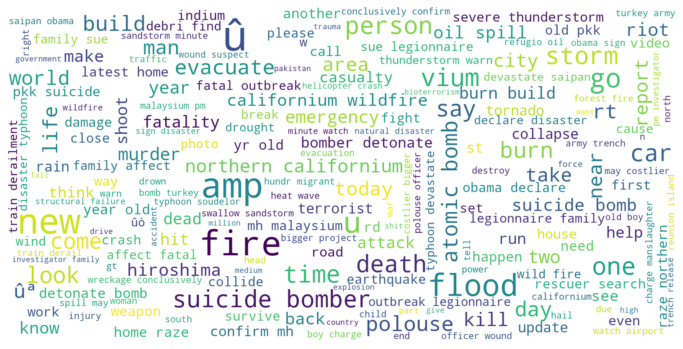

In [79]:
#Disaster Tweets wordcloud 
disaster_tweets = train[train['target'] == 1]
disaster_string = []
for t in disaster_tweets.text:
    disaster_string.append(t)
disaster_string = pd.Series(disaster_string).str.cat(sep=' ')
wordcloud = WordCloud(width=1600, height=800,max_font_size=100, background_color='white').generate(disaster_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

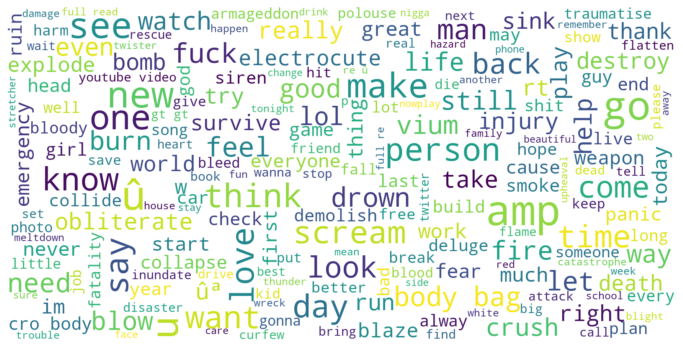

In [80]:
# Positive tweets wordcloud
formal_tweets = train[train["target"] == 0]
formal_string = []
for t in formal_tweets.text:
    formal_string.append(t)
formal_string = pd.Series(formal_string).str.cat(sep=' ')
wordcloud = WordCloud(width=1600, height=800,max_font_size=100, background_color='white').generate(formal_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# BERT 

In [81]:
tokenizer = AutoTokenizer.from_pretrained('bert-large-uncased')
bert = TFBertModel.from_pretrained('bert-large-uncased')

Some layers from the model checkpoint at bert-large-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-large-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [82]:
tokenizer('Prediciendo tweets')

{'input_ids': [101, 3653, 14808, 9013, 3527, 1056, 28394, 3215, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [83]:
print("max len of tweets",max([len(x.split()) for x in train['text']]))
max_length = 36

max len of tweets 25


In [84]:
x_train = tokenizer(
    text=train['text'].tolist(),
    add_special_tokens=True,
    max_length=36,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

In [85]:
x_train['input_ids'].shape

TensorShape([7613, 36])

In [86]:
x_train['attention_mask'].shape

TensorShape([7613, 36])

In [87]:
y_train = train['target'].values

In [88]:
y_train

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [89]:
train['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

## Construyendo el modelo

In [90]:
input_ids = Input(shape=(max_length,), dtype=tensorflow.int32, name="input_ids")
input_mask = Input(shape=(max_length,), dtype=tensorflow.int32, name="attention_mask")

embeddings = bert(input_ids,attention_mask = input_mask)[1] 
out = tensorflow.keras.layers.Dropout(0.1)(embeddings)

out = Dense(128, activation='relu')(out)
out = tensorflow.keras.layers.Dropout(0.1)(out)
out = Dense(32,activation = 'relu')(out)

y = Dense(1,activation = 'sigmoid')(out)
    
model = tensorflow.keras.Model(inputs=[input_ids, input_mask], outputs=y)
model.layers[2].trainable = True


In [91]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 36)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 36)]         0           []                               
                                                                                                  
 tf_bert_model_2 (TFBertModel)  TFBaseModelOutputWi  335141888   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 36,                                          

In [92]:
optimizer = Adam(
    learning_rate=6e-06, # this learning rate is for bert model.
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)

# Set loss and metrics
loss = BinaryCrossentropy(from_logits = True)
metric = BinaryAccuracy('accuracy'),

# Compile the model
model.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = metric)

## Entrenamiento del modelo

In [93]:
# Fit the model
final = model.fit(
    x ={'input_ids':x_train['input_ids'],'attention_mask':x_train['attention_mask']} ,
    y = y_train,
    epochs=4,
    batch_size=10
)

Epoch 1/4


C:\Users\andre\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


762/762 [==============================] - 3031s 4s/step - loss: 0.5320 - accuracy: 0.7448
Epoch 2/4
762/762 [==============================] - 2952s 4s/step - loss: 0.4481 - accuracy: 0.8077
Epoch 3/4
762/762 [==============================] - 2920s 4s/step - loss: 0.4255 - accuracy: 0.8189
Epoch 4/4
762/762 [==============================] - 2930s 4s/step - loss: 0.4184 - accuracy: 0.8239


## Precision y perdida

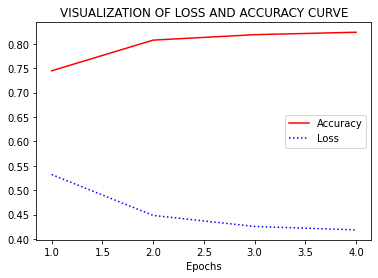

In [94]:
def visual_accuracy_and_loss(final):
    acc = final.history['accuracy']
    loss = final.history['loss']
    epochs_plot = np.arange(1, len(loss) + 1)
    plt.clf()
    plt.plot(epochs_plot, acc, 'r', label='Accuracy')
    plt.plot(epochs_plot, loss, 'b:', label='Loss')
    plt.title('VISUALIZATION OF LOSS AND ACCURACY CURVE')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

visual_accuracy_and_loss(final)

In [95]:
x_test = tokenizer(
    text=test.text.tolist(),
    add_special_tokens=True,
    max_length=36,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

In [96]:
x_test

{'input_ids': <tf.Tensor: shape=(3263, 36), dtype=int32, numpy=
array([[  101,  2074,  3047, ...,     0,     0,     0],
       [  101,  2657,  2055, ...,     0,     0,     0],
       [  101,  2045,  2003, ...,     0,     0,     0],
       ...,
       [  101,  2665,  2240, ...,     0,     0,     0],
       [  101, 12669,  3314, ...,     0,     0,     0],
       [  101,  1001,  2103, ...,     0,     0,     0]])>, 'attention_mask': <tf.Tensor: shape=(3263, 36), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])>}

## Prediccion

In [97]:
predicted = model.predict({'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']})

102/102 [==============================] - 277s 3s/step


In [98]:
y_predicted = np.where(predicted>0.5,1,0)

In [99]:
y_predicted = y_predicted.reshape((1,3263))[0]

In [100]:
y_predicted

array([1, 0, 1, ..., 1, 1, 1])

In [101]:
result = pd.DataFrame()
result['id'] = test.id
result['text'] = test.text
result['target'] = y_predicted

In [102]:
result.head()

,id,text,target
0,0,Just happened a terrible car crash,1
1,2,"Heard about #earthquake is different cities, s...",0
2,3,"there is a forest fire at spot pond, geese are...",1
3,9,Apocalypse lighting. #Spokane #wildfires,1
4,11,Typhoon Soudelor kills 28 in China and Taiwan,1


## Comprobando las predicciones

In [103]:
X_test_prediction = tokenizer(
    text=train['text'].tolist(),
    add_special_tokens=True,
    max_length=36,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

In [104]:
test_prediction = model.predict({'input_ids':X_test_prediction['input_ids'],'attention_mask':X_test_prediction['attention_mask']})

238/238 [==============================] - 575s 2s/step


In [105]:
y_predicted_test = np.where(test_prediction>0.5,1,0)

In [106]:
y_predicted_test = y_predicted_test.reshape((1,len(y_predicted_test)))[0]

In [107]:
train['predicted_val'] = y_predicted_test

In [108]:
print("Accuracy:", accuracy_score(train['target'], train['predicted_val']))

Accuracy: 0.8404045711283331


# Funcion de prediccion

In [112]:
def functionToPredict(test_data):
    text_to_predict = tokenizer(
    t   ext=test_data['text'].tolist(),
        add_special_tokens=True,
        max_length=36,
        truncation=True,
        padding=True, 
        return_tensors='tf',
        return_token_type_ids = False,
        return_attention_mask = True,
        verbose = True
    )

    test_prediction = model.predict({'input_ids':text_to_predict['input_ids'],'attention_mask':text_to_predict['attention_mask']})

    y_predicted_test = np.where(test_prediction>0.5,1,0)

    y_predicted_test = y_predicted_test.reshape((1,len(y_predicted_test)))[0]

    return y_predicted_test

In [134]:
test_data = test.copy()
test_data.head()

   id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2     NaN      NaN  Heard about #earthquake is different cities, s...
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
4  11     NaN      NaN      Typhoon Soudelor kills 28 in China and Taiwan


In [132]:
test_data.loc[test_data['id'] == 0, 'text'] = 'Yesterday I went to the dentist'
test_data.loc[test_data['id'] == 2, 'text']  = 'A car crashed in front of me'
test_data.loc[test_data['id'] == 3, 'text'] = 'My kid is a bomb!'
test_data.loc[test_data['id'] == 9, 'text'] = 'An earthquake killed 5 persons'
test_data.loc[test_data['id'] == 11, 'text'] = 'Too much traffic!!!'
# test_data[5]['text']  = 'An earthquake killed 5 persons'
# test_data[6]['text']  = 'Typhoon destroyed houses'
# test_data[7]['text']  = 'A girl who died in an airplane accident fifteen years ago'
# test_data[8]['text']  = 'I am going into a panic attack'

In [133]:
test_data.head()

,id,keyword,location,text
0,0,NaN,NaN,Yesterday I went to the dentist
1,2,NaN,NaN,A car crashed in front of me
2,3,NaN,NaN,My kid is a bomb!
3,9,NaN,NaN,An earthquake killed 5 persons
4,11,NaN,NaN,Too much traffic!!!


In [ ]:
y_predicted_test = functionToPredict(test_data)